# Classifying the Type of Dry Bean by Group 99

## Introduction

Beans are an important crop and source of nutrition for people around the world.  Dry beans are a variety of bean that can used in cooking or planted and used to grow new beans. The dry bean dataset stores data that can be used to tell apart 7 similar dry bean species (Seker, Barbunya, Bombay, Cali, Dermosan, Horoz & Sira). Using this dataset our predictive question is what is the class of an unknown dry bean based on certain attributes? The dataset includes sixteen different measurements in pixels collected using a camera and computer analysis (see Kiratiratanapruk and Sinthupinyo 2011). These include 
- area
- perimeter
- major axis length (longest length)
- minor axis length (longest length perpendicular to major axis length)
- aspect ratio (major vs minor axis length)
- eccentricity (compares curve of ellipse to the region)
- convex area (area of smallest polygon bean fits in)
- equivalent diameter (diameter of circle the same size as bean)
- extent (ratio of pixels in box around bean compared to bean)
- solidity (pixels in convex shell vs bean), roundness ((4piA)/(P^2))
- and shapeFactors 1-4

Using some of this information we aim to create an accurate and useful predictive model to help tell apart visually similar beans.

## Methods Part 1

First, we installed libraries and downloaded the data via url so the code is reproducible for any user

## Data Analysis

In [31]:
#setup cell

library(tidyverse)#importing tidyverse(basic library)
library(GGally)
library(tidymodels)
library(repr)
options(repr.plot.width = 12, repr.plot.height = 30) #sets the width and height of the tables so it's easily viewable
options(repr.matrix.max.rows = 6) #Makes the tables less annoying to look at


In [32]:
#reading data for prelim. analysis from the training dataset in the data folder
#The data is in a tidy format already

url <- "https://raw.githubusercontent.com/dhawal-rathore/DSCI100-Group-Project/main/data/bean_training.csv?token=GHSAT0AAAAAAB3WRVPDBR67X7A5D44MLMDGY4RLQ6A"
bean_data_full <- read_csv(url)
bean_data_full

Rows: 2500 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Class
dbl (16): Area, Perimeter, MajorAxisLength, MinorAxisLength, AspectRation, E...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
69892,1052.973,389.8558,228.6715,1.704873,0.8099101,71139,298.3107,0.6842698,0.9824709,0.7921417,0.7651821,0.005577974,0.001179548,0.5855037,0.9982094,BARBUNYA
34584,704.813,272.4484,161.9722,1.682068,0.8040911,34940,209.8421,0.6781708,0.9898111,0.8748574,0.7702088,0.007877873,0.001710104,0.5932216,0.9978393,DERMASON
72102,1072.061,377.6167,243.5039,1.550763,0.7643142,73400,302.9903,0.7084521,0.9823161,0.7883484,0.8023752,0.005237257,0.001339040,0.6438059,0.9983902,BARBUNYA
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
81774,1082.182,400.8847,261.5089,1.532968,0.7579356,82581,322.6730,0.8211560,0.9902278,0.8774543,0.8049024,0.004902349,0.001269278,0.6478678,0.9931606,CALI
41619,741.440,261.1094,203.2729,1.284526,0.6276480,41975,230.1976,0.7963835,0.9915188,0.9513701,0.8816139,0.006273802,0.002337891,0.7772430,0.9983889,SEKER
50043,894.418,357.3190,179.9019,1.986189,0.8640087,50848,252.4217,0.6224254,0.9841685,0.7860898,0.7064323,0.007140240,0.001096920,0.4990466,0.9912008,HOROZ


## Methods Part 2

Next we cleaned the data by selecting useful predictors.

We used the function ggpair (figure 1) to evaluate all predictors. Based on the distributions of the variables and variation between the classes in figure 1 we selected our predictors. We selected observations with wide distributions or minimally overlapping distributions for the classes to ensure our program could differentiate between beans. This allowed us to eliminate area, convex area, and solidity. Additionally, we removed Shapefactors 1:4 as the metadata is unclear about what they represent, rendering the measurement non-reproducible.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



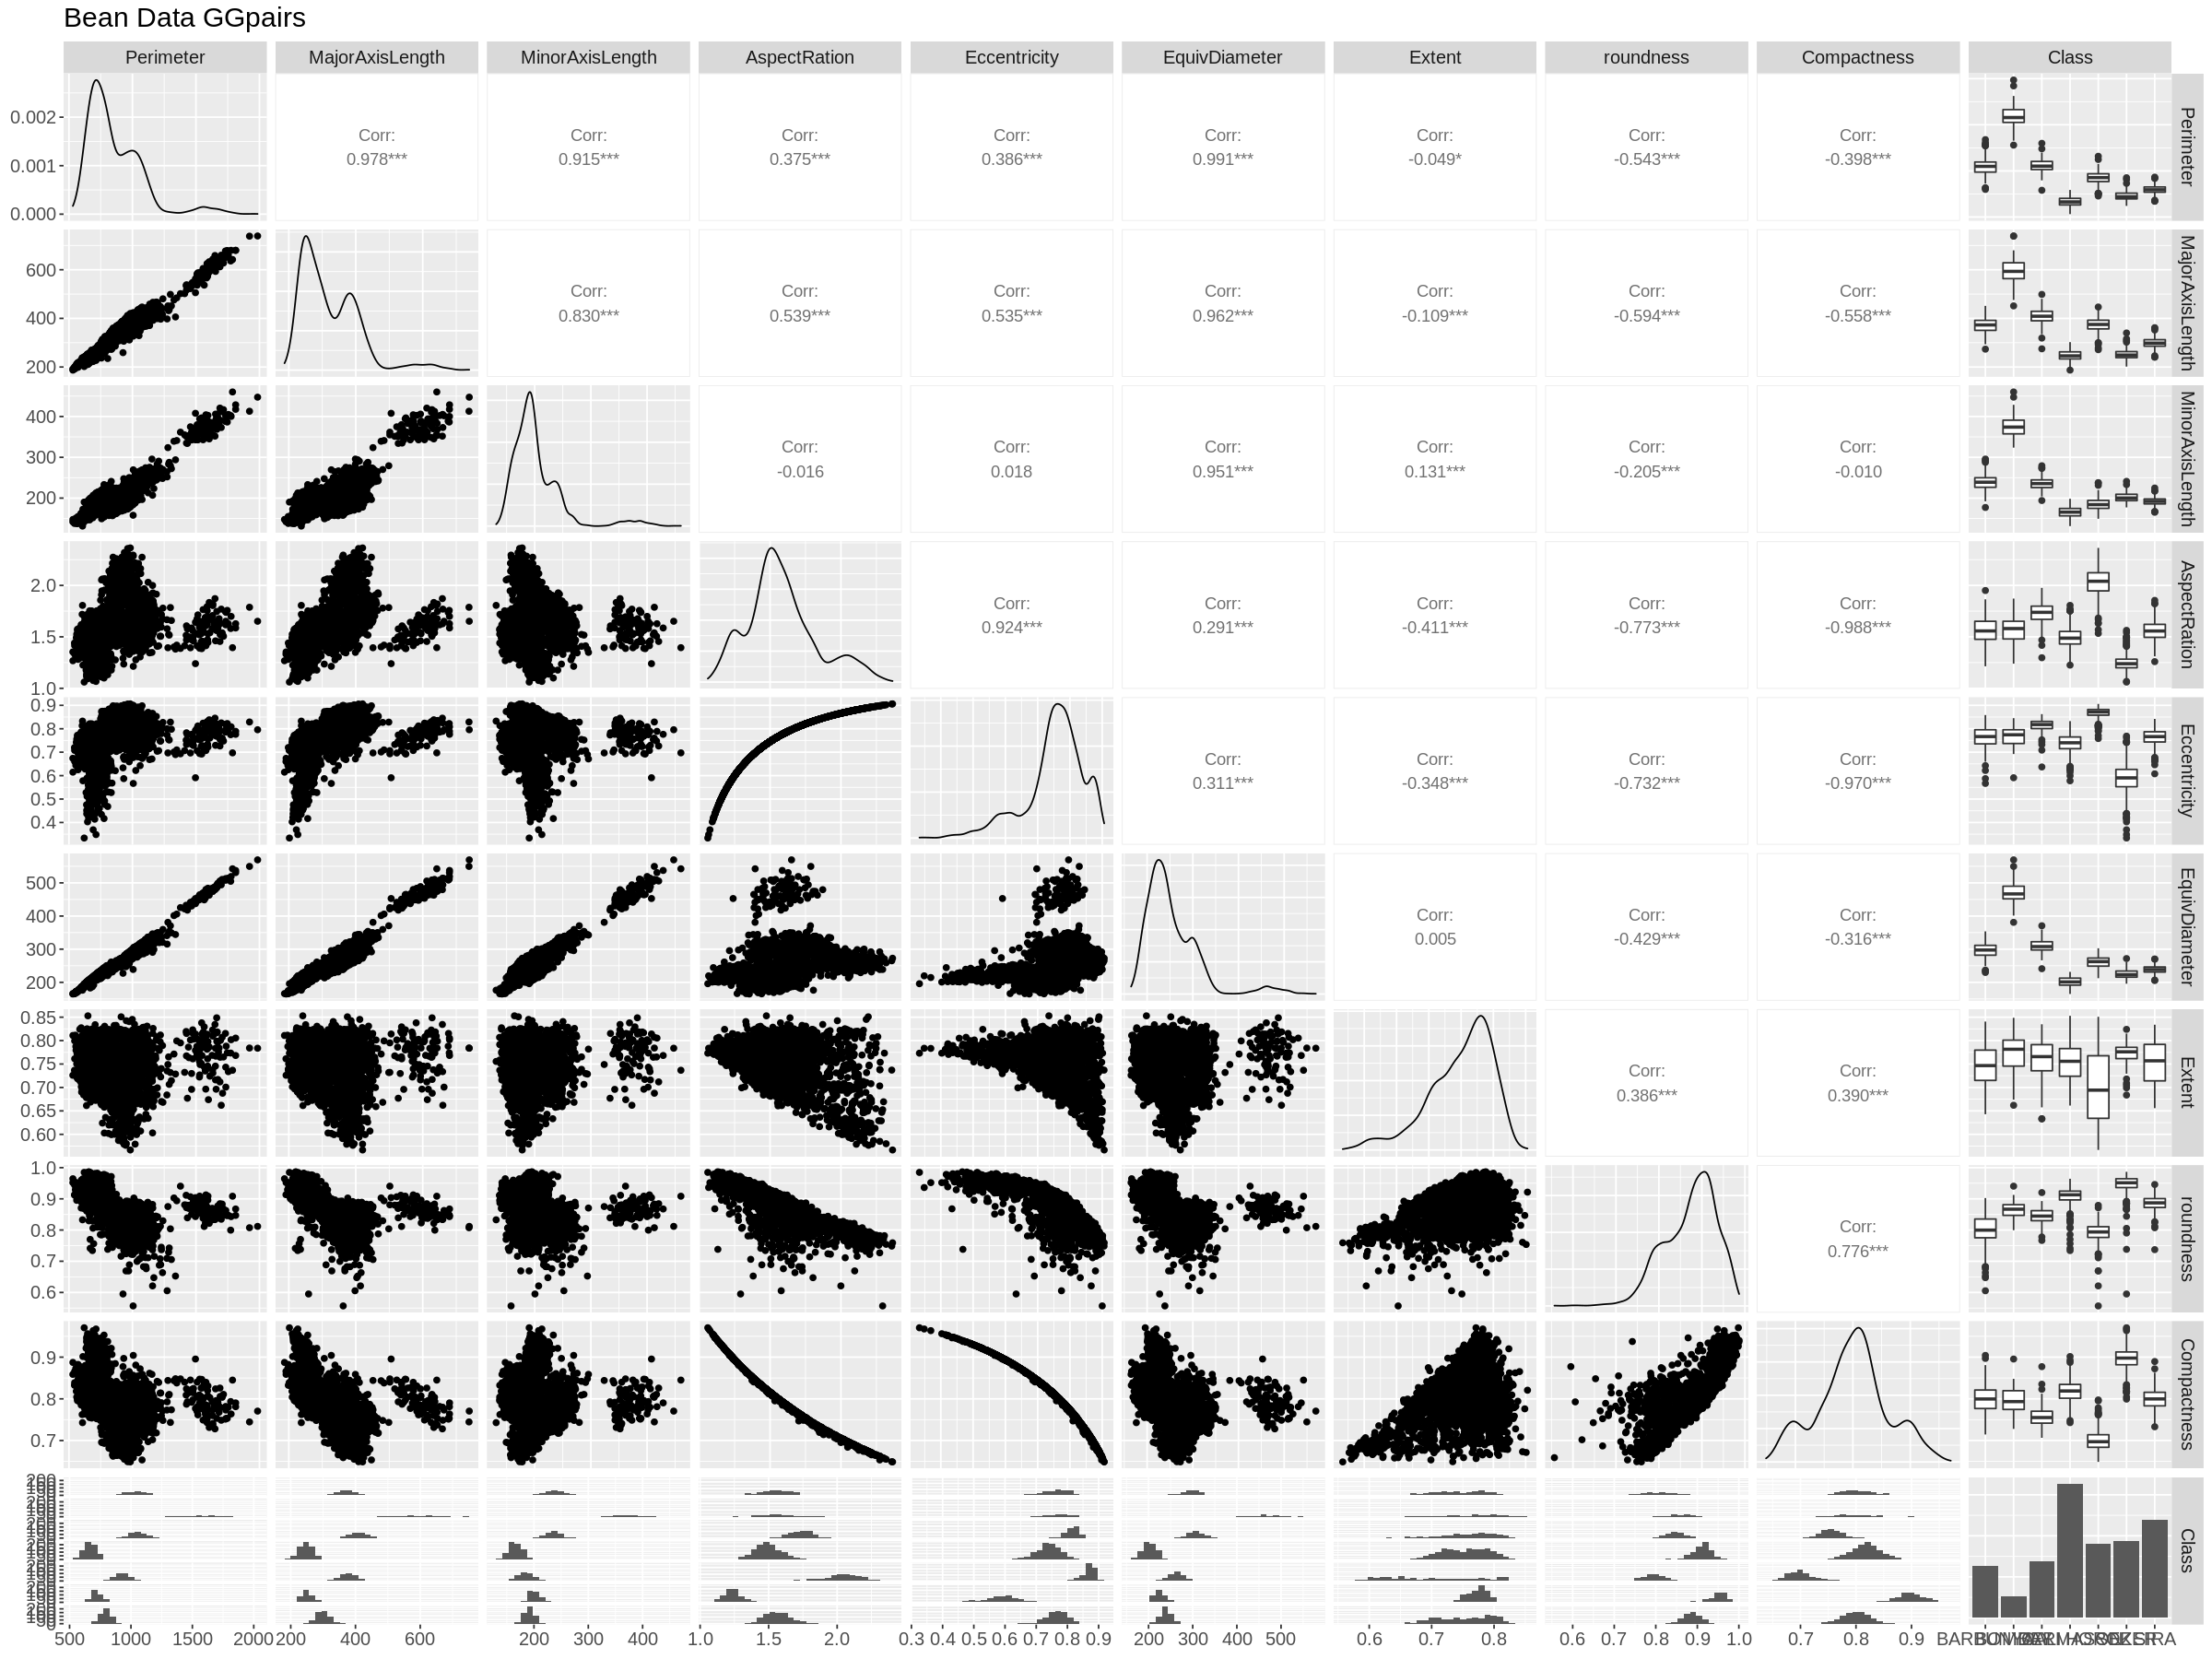

In [11]:
#Here we look at the distribution and means of the different variables to choose which to include in our dataset
options(repr.plot.width = 20, repr.plot.height = 15)
bean_ggpairs <- bean_data_full |>
    ggpairs() +
    ggtitle("Bean Data GGpairs") +
    theme(text = element_text(size = 15))

bean_ggpairs

Figure 1. GGpairs analysis of all included observations. This figures details correlations, overall distributions, and distributions for each class for every predictor.

## Methods part 2b

Here, we remove predictors we eliminated above as well as split the data into training and testing sets with initial_split(). To make this process reproducible, we set the seed in this cell.

In [33]:
#removing the predictors we are not using
bean_data_full <- bean_data_full |>
    select(-Area,-ConvexArea,-Solidity,-(ShapeFactor1:ShapeFactor4))

#Set the seed and split the data
set.seed(2020)

bean_split<-initial_split(bean_data_full, prop=0.8, strata = Class )
bean_data_train<-training(bean_split)
bean_data_test<-testing(bean_split)

bean_data<-tibble(bean_data_train)

## Methods Part 3

We produced summary tables of the number of beans, mean, standard deviation, maximum, and minimum values for each variable. Below we analyzed the summary tables which helps us double-check the effectiveness of the selected columns. Additionally, the number of beans in each class will help us decide whether to balance the data.

In [21]:
#We want to see how many beans of each class there are to make sure there are a reasonable amount of all 7
bean_number_table <- bean_data |>
    group_by(Class) |>
    summarize(number_beans = n())
    
bean_number_table

Class,number_beans
<chr>,<int>
BARBUNYA,200
BOMBAY,76
CALI,221
⋮,⋮
HOROZ,293
SEKER,300
SIRA,385


Table 1. Number of beans in each class. 

From this table, we see that most classes have a high number of observations (200-300). This shows the classes are mostly balanced. However, we see that some classes have a significantly smaller number of observations (e.g. bombay), therefore we will want to balance the classes such that the prediction is not skewed.

In [24]:
#Table of the mean values for every predictor and bean class
bean_mean_table <- bean_data |>
    group_by(Class) |>
    summarize(across(Perimeter:Compactness, mean, na.rm = TRUE))

bean_mean_table <- rename(bean_mean_table,
                          MeanPerimeter = Perimeter,
                         MeanMajorAxisLength = MajorAxisLength,
                         MeanMinorAxisLength = MinorAxisLength,
                         MeanAspectRation = AspectRation,
                         MeanEccentricity = Eccentricity,
                         MeanEquivDiameter = EquivDiameter,
                         MeanExtent = Extent,
                         MeanRoundness = roundness,
                         MeanCompactness = Compactness)

bean_mean_table

Class,MeanPerimeter,MeanMajorAxisLength,MeanMinorAxisLength,MeanAspectRation,MeanEccentricity,MeanEquivDiameter,MeanExtent,MeanRoundness,MeanCompactness
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BARBUNYA,1045.817,371.4615,238.4471,1.561741,0.7617599,296.7644,0.7461158,0.7979752,0.8003492
BOMBAY,1587.628,592.4269,376.2672,1.576946,0.7670996,469.8245,0.7735341,0.8652081,0.7949293
CALI,1056.982,409.2270,235.5469,1.738507,0.8155098,308.9535,0.7571688,0.8439545,0.7559800
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
HOROZ,924.1612,373.9007,184.8610,2.027262,0.8674803,261.6319,0.6990235,0.7923428,0.7006444
SEKER,726.5133,251.1426,201.4032,1.247486,0.5868200,224.6107,0.7724583,0.9447119,0.8960563
SIRA,797.2829,299.2486,191.7457,1.561584,0.7644027,238.8382,0.7544466,0.8864460,0.7993497


Table 2. Distribution of the means of each bean class. 

We observe from this table that perimeter, major axis length, and equivalent diameter have the most divergence in their means between classes. This indicates they may be some of the most useful predictors for differentiating beans.

In [25]:
#Table of the standard deviation for every predictor and bean class
bean_sd_table <- bean_data |>
    group_by(Class) |>
    summarize(across(Perimeter:Compactness, sd, na.rm = TRUE))

bean_sd_table <- rename(bean_sd_table,
                          SDPerimeter = Perimeter,
                         SDMajorAxisLength = MajorAxisLength,
                         SDMinorAxisLength = MinorAxisLength,
                         SDAspectRation = AspectRation,
                         SDEccentricity = Eccentricity,
                         SDEquivDiameter = EquivDiameter,
                         SDExtent = Extent,
                         SDRoundness = roundness,
                         SDCompactness = Compactness)
bean_sd_table

Class,SDPerimeter,SDMajorAxisLength,SDMinorAxisLength,SDAspectRation,SDEccentricity,SDEquivDiameter,SDExtent,SDRoundness,SDCompactness
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BARBUNYA,92.33782,32.29933,19.34937,0.12131913,0.04562230,22.10693,0.04078589,0.04904295,0.03159194
BOMBAY,112.16957,50.86790,25.52973,0.12323399,0.04417902,31.05259,0.04097212,0.02510942,0.03238286
CALI,67.23587,29.68902,13.95393,0.09842087,0.02618064,18.57815,0.04356990,0.02401081,0.02274609
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
HOROZ,68.11756,28.88487,14.273739,0.13911763,0.02165530,17.85044,0.07517298,0.03222076,0.02419187
SEKER,46.09532,19.53697,10.196310,0.08226966,0.07124557,12.69887,0.01872555,0.03227498,0.02882460
SIRA,44.97107,20.69143,9.324165,0.09407877,0.03342470,12.29703,0.04392692,0.02242614,0.02434794


Table 3. Standard deviation of each predictor for bean classes. 

We observe from this table that perimeter, major axis length, minor axis length, and equivalent diameter have the greatest standard deviation across the bean classes indicating these predictors may be particularly useful.

In [26]:
#Table of the maximum value for every predictor and bean class
bean_max_table <- bean_data |>
    group_by(Class) |>
    summarize(across(Perimeter:Compactness, max, na.rm = TRUE))

bean_max_table <- rename(bean_max_table,
                          MaxPerimeter = Perimeter,
                         MaxMajorAxisLength = MajorAxisLength,
                         MaxMinorAxisLength = MinorAxisLength,
                         MaxAspectRation = AspectRation,
                         MaxEccentricity = Eccentricity,
                         MaxEquivDiameter = EquivDiameter,
                         MaxExtent = Extent,
                         MaxRoundness = roundness,
                         MaxCompactness = Compactness)
bean_max_table

Class,MaxPerimeter,MaxMajorAxisLength,MaxMinorAxisLength,MaxAspectRation,MaxEccentricity,MaxEquivDiameter,MaxExtent,MaxRoundness,MaxCompactness
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BARBUNYA,1306.551,451.4417,290.6016,1.950371,0.8585541,353.7374,0.8241160,0.9026236,0.9042299
BOMBAY,1985.370,738.8602,460.1985,1.834076,0.8382840,569.3744,0.8486226,0.9405877,0.8955188
CALI,1298.822,498.5978,279.3503,1.976405,0.8625515,370.6704,0.8347987,0.9200291,0.8772729
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
HOROZ,1158.389,442.2778,237.8999,2.364017,0.9061255,302.8011,0.8507442,0.8714311,0.7973910
SEKER,925.731,339.9315,231.9879,1.563090,0.7685762,271.7356,0.8239707,0.9866847,0.9705155
SIRA,932.171,361.6974,224.7293,1.825598,0.8366318,270.4252,0.8339256,0.9460660,0.8895254


Table 4. Maximum value for each bean class and each predictor.

We once again observe the most difference between beans in perimeter, major axis length, minor axis length, and equivalent diameter. This reinforces them as useful predictors.

In [27]:
#Table of the minimum value for every predictor and bean class
bean_min_table <- bean_data |>
    group_by(Class) |>
    summarize(across(Perimeter:Compactness, min, na.rm = TRUE))

bean_min_table <- rename(bean_min_table,
                          MinPerimeter = Perimeter,
                         MinMajorAxisLength = MajorAxisLength,
                         MinMinorAxisLength = MinorAxisLength,
                         MinAspectRation = AspectRation,
                         MinEccentricity = Eccentricity,
                         MinEquivDiameter = EquivDiameter,
                         MinExtent = Extent,
                         MinRoundness = roundness,
                         MinCompactness = Compactness)
bean_min_table

Class,MinPerimeter,MinMajorAxisLength,MinMinorAxisLength,MinAspectRation,MinEccentricity,MinEquivDiameter,MinExtent,MinRoundness,MinCompactness
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BARBUNYA,799.426,273.4029,192.1112,1.213649,0.5666462,234.3799,0.6640389,0.6053994,0.7144941
BOMBAY,1279.356,451.3613,323.7480,1.239630,0.5909720,380.9913,0.6620129,0.8113826,0.7313228
CALI,789.770,274.8634,194.0923,1.297228,0.6369871,241.1302,0.6329370,0.7666379,0.7065331
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
HOROZ,727.659,271.1585,149.3573,1.533630,0.7581778,213.3651,0.5666693,0.5567658,0.6487620
SEKER,620.134,201.8479,177.1582,1.060798,0.3336797,195.8965,0.6837958,0.5950484,0.7993834
SIRA,670.488,240.3770,165.2836,1.259251,0.6077571,205.5385,0.6559318,0.7371985,0.7385667


Table 5. Minimum value for each bean class and each predictor. 

We once again observe the most difference between beans in perimeter, major axis length, minor axis length, and equivalent diameter. Since these predictors show divergence across all summary statistics, we can infer that they will be the best predictors to differentiate the bean classes.

## Methods Part 4

The summary tables allowed further investigation into which columns might have the most different values for classes. Of the columns we analyzed perimeter, major axis length, minor axis length, and equivalent diameter had the most distinct means, minimums, and maximums as well as larger standard deviations. This shows these could be particularly useful predictors out of the nine we already picked. Additionally, before we make the model we will balance the classes since the table showed they are slightly imbalanced.

In [28]:
install.packages("themis")
library(themis)

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [29]:
#going to balance the classes as we saw above they are imbalanced
library(themis)

bean_balance_recipe <- recipe(Class ~ ., data = bean_data) |>
  step_upsample(Class, over_ratio = 1, skip = FALSE) |>
  prep()

bean_data <- bake(bean_balance_recipe, bean_data)

upsampled_bean <- bean_data |>
  group_by(Class) |>
  summarize(n = n())

upsampled_bean

Class,n
<fct>,<int>
BARBUNYA,522
BOMBAY,522
CALI,522
⋮,⋮
HOROZ,522
SEKER,522
SIRA,522


Table 6. Summary of balanced bean classes. Each class now has the same number of observations lending it the same weight in our predictor model.

## Methods Part 5

To better visualize the relationship between variables, we decided to produce multiple scatterplots using pairwise combinations of the 9 selected variables. On the plots, we used color to distinguish bean types.

Below, we graph some predictors we identified above as useful with the summary statistics. This allows us to visualize difference between classes as well as select useful pariwise combinations of predictors. Ideally, we would like to decrease the number of predictors from nine to two or three. This is because it will improve the interpretability of our model as well allow for easier program analysis and simplify future measurements.

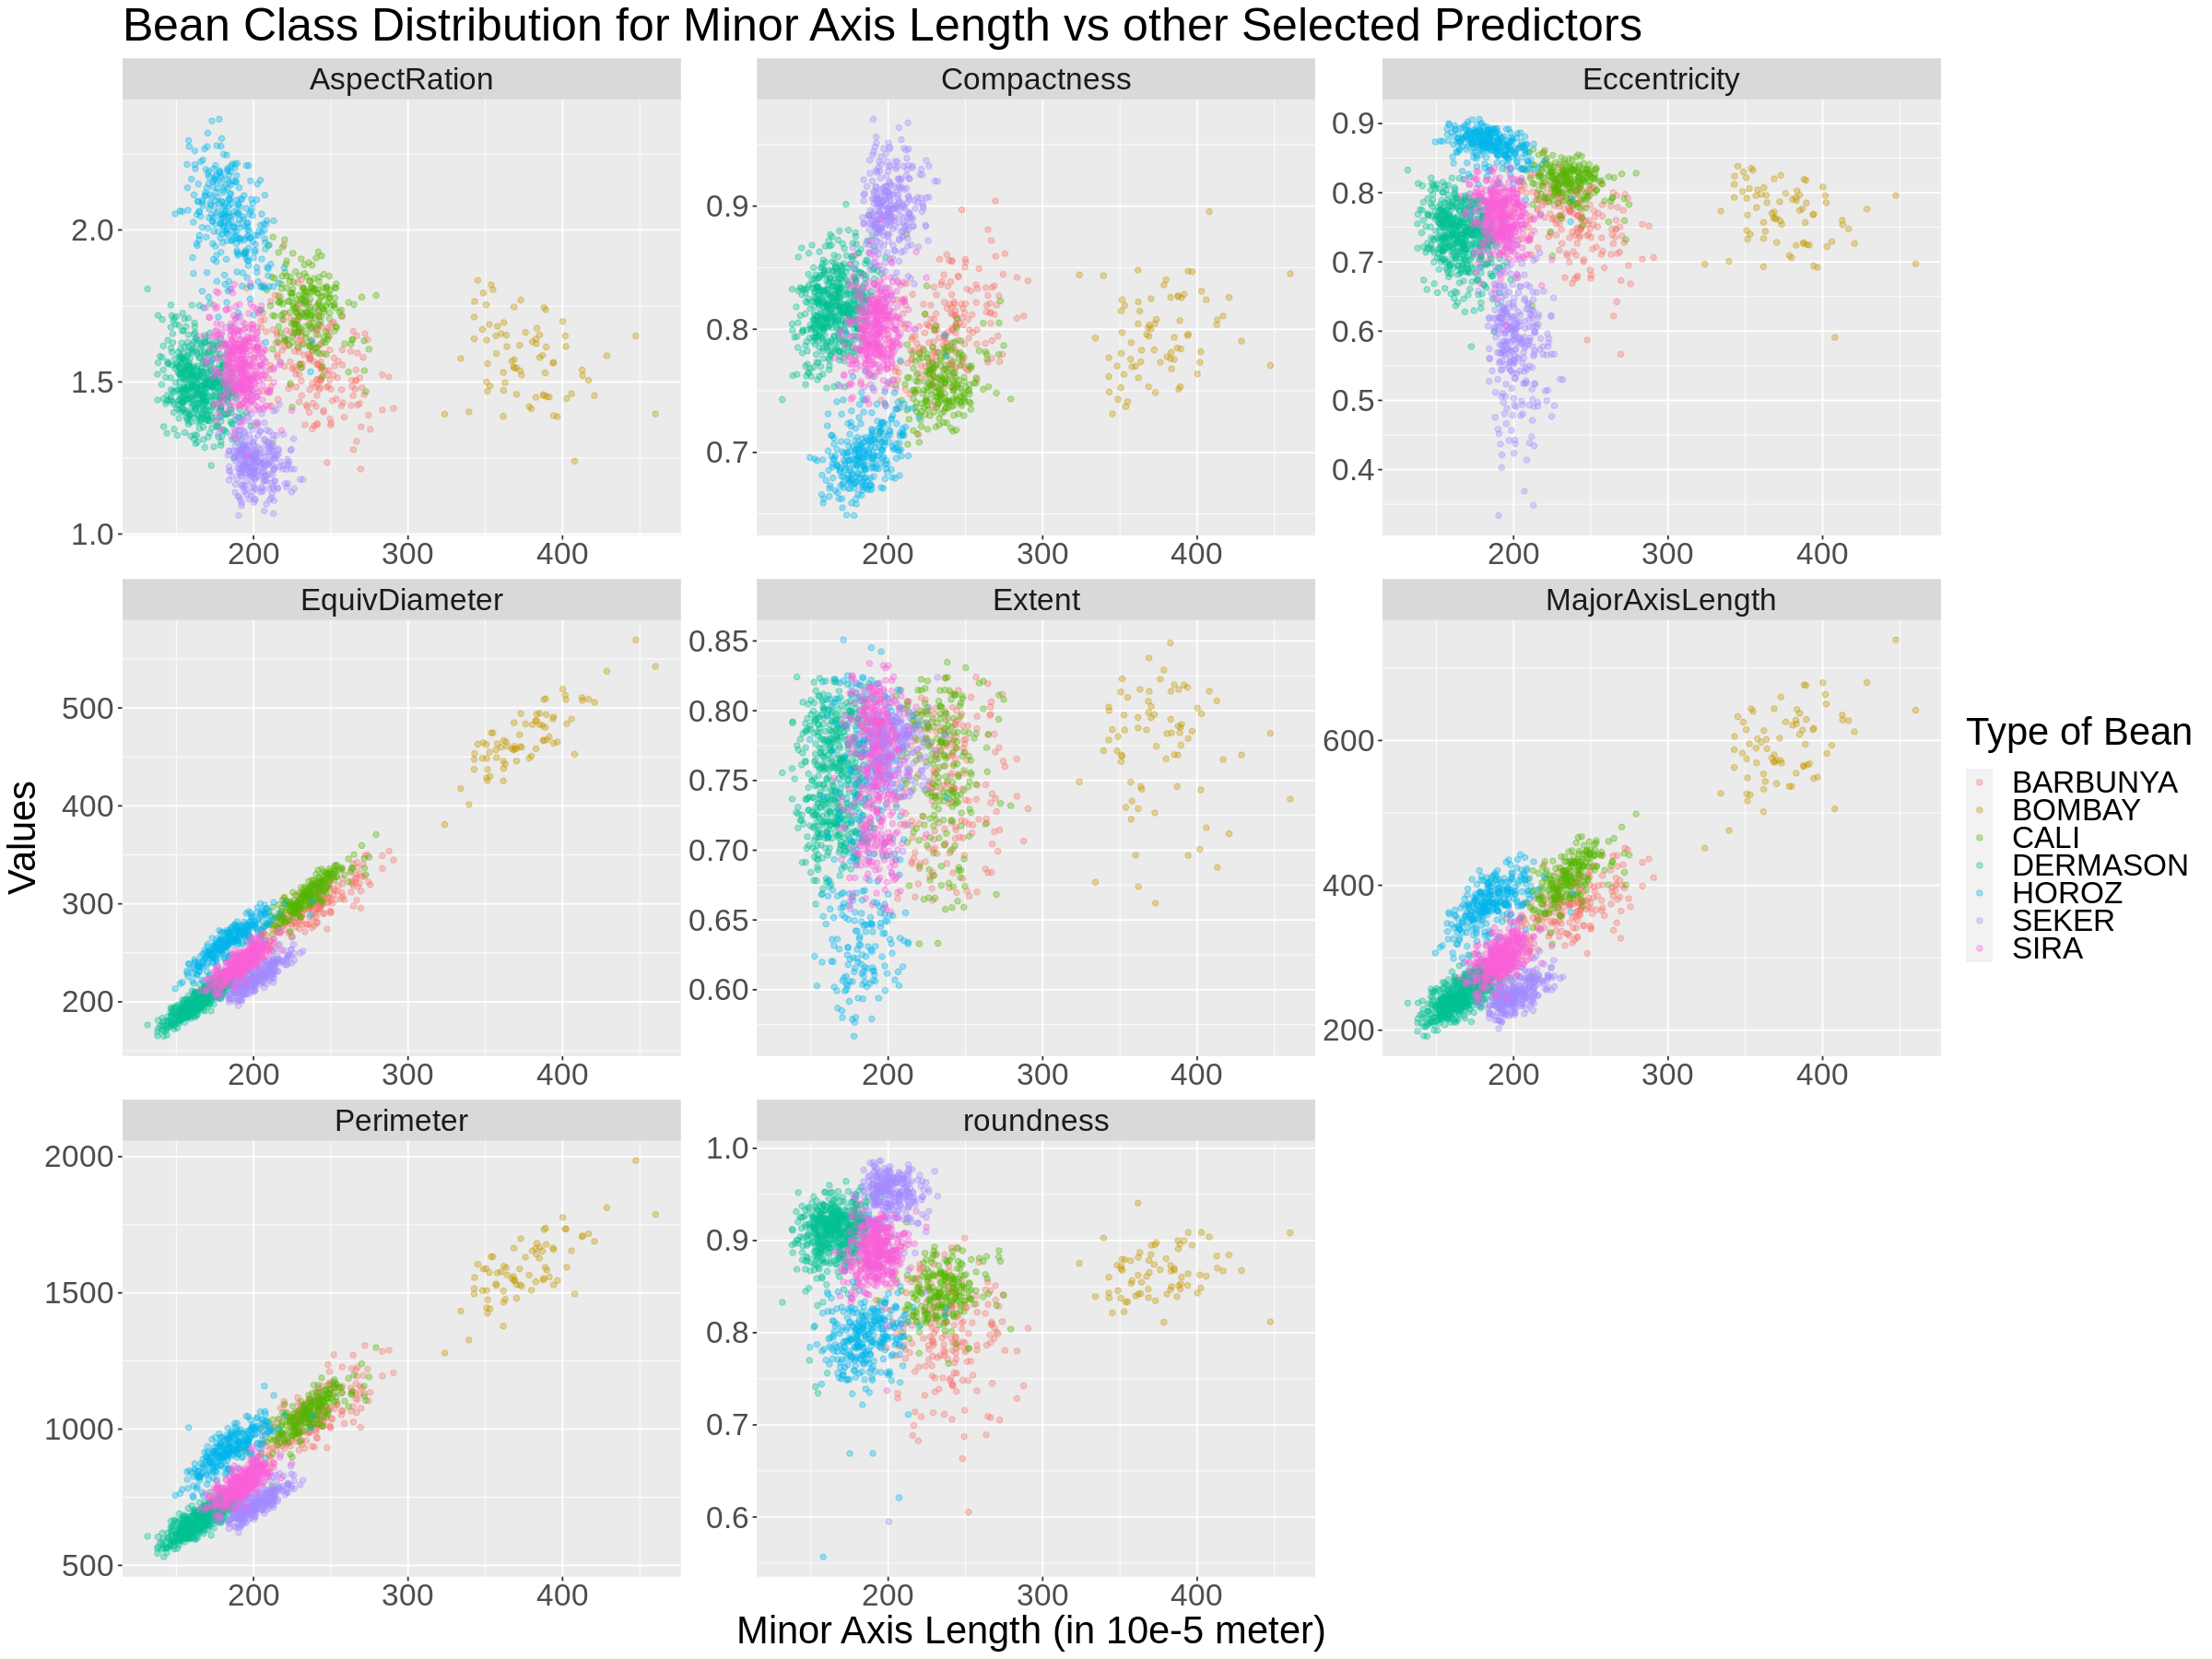

In [14]:
#Graph of minor axis length against other variables
bean_data <- bean_data |>
    relocate(MinorAxisLength, 1)

bean_MLA_plots <-bean_data |>
        pivot_longer(
        cols= Perimeter:Compactness,
        names_to="factor",
        values_to="values")

bean_MLA_plot<-bean_MLA_plots|>
    ggplot(aes(x=MinorAxisLength,y=values,color=Class))+
    geom_point(alpha=0.35)+
    facet_wrap(factor~.,scales="free")+
    labs(x="Minor Axis Length (in 10e-5 meter)",y="Values",color="Type of Bean", title = "Bean Class Distribution for Minor Axis Length vs other Selected Predictors") +
    theme(text = element_text(size = 25))
bean_MLA_plot

Figure 2. Pairwise bean class distributions for minor axis length (MLA) and other predictors variables. 

In figure 2, we identify MLA and aspect ratio, MLA and compactness, MLA and eccentricity, and MLA and roundness as useful combinations. This is because bean classes form distinct clusters which will allow the program to better differentiate between them. Additionally, some combinations have strong positive correlations, likely because minor axis length and the predictor are highly related measurements. We want to ignore these as they do not bring two distinct measurements and do not help us differentiate beans.

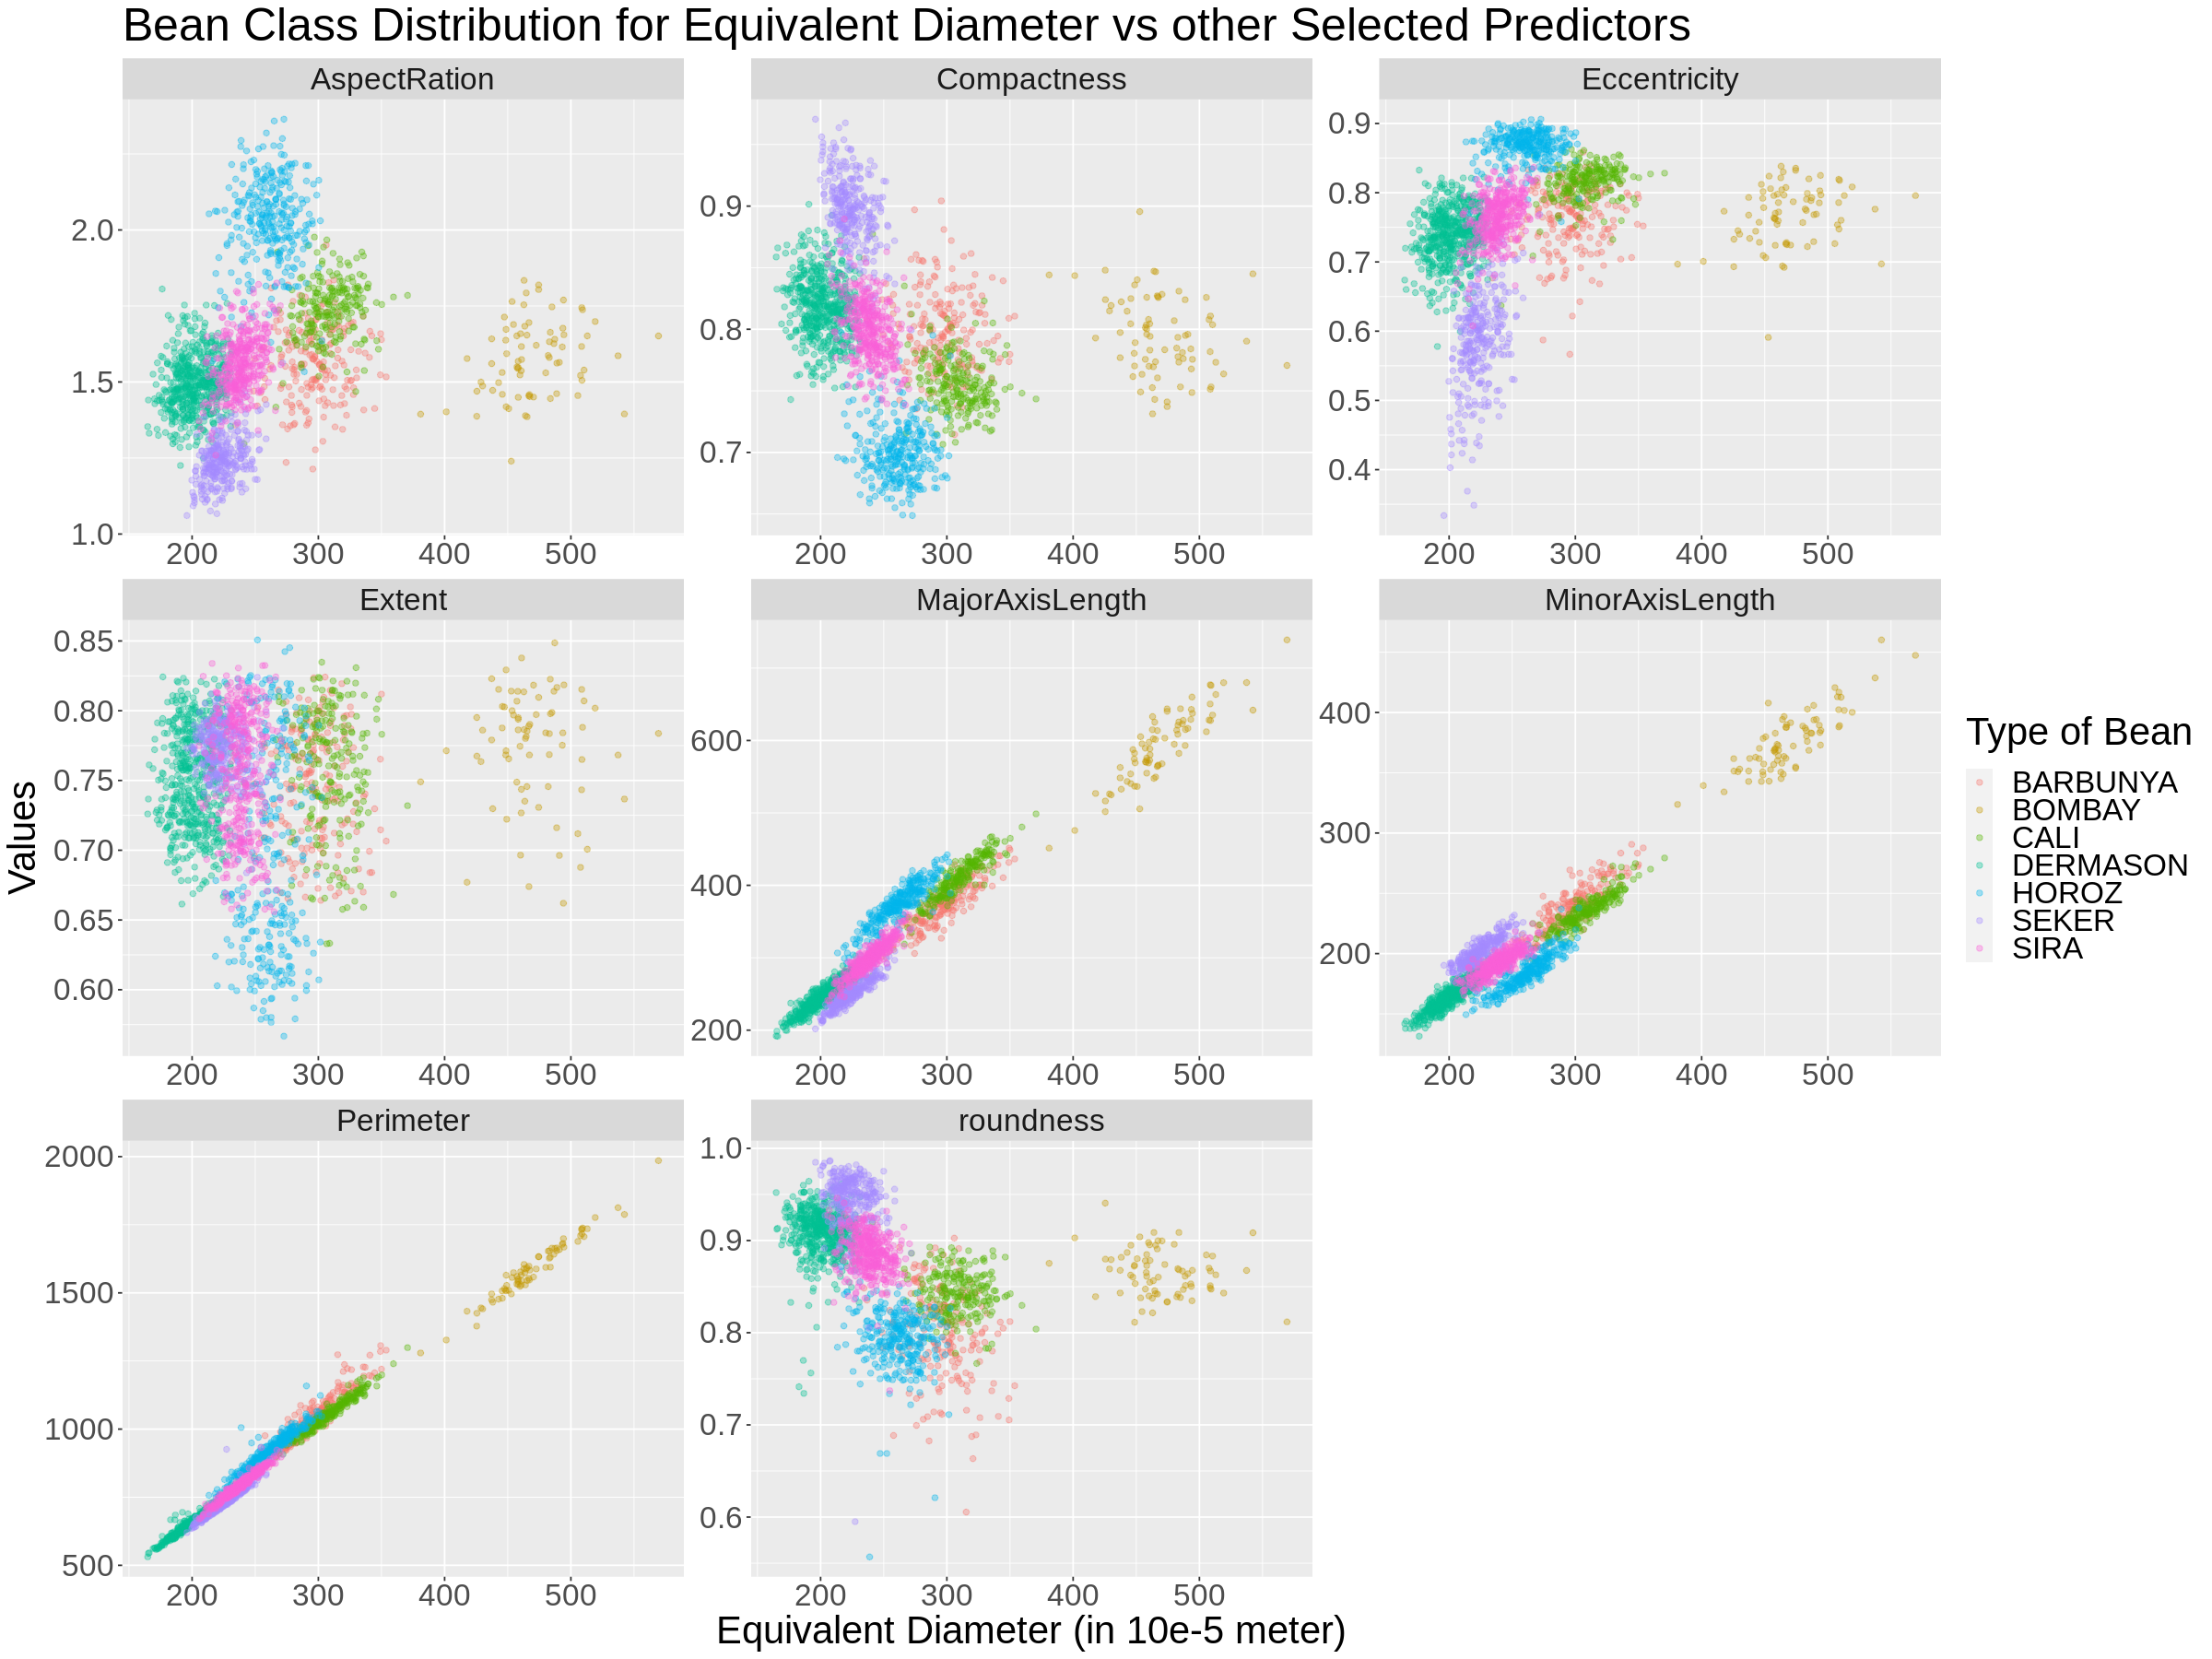

In [15]:
#Graph of EquivDiameter against other variables
bean_data <- bean_data |>
    relocate(EquivDiameter, 1)

bean_ED_plots <-bean_data |>
        pivot_longer(
        cols= MinorAxisLength:Compactness,
        names_to="factor",
        values_to="values")

bean_ED_plot<-bean_ED_plots|>
    ggplot(aes(x=EquivDiameter,y=values,color=Class))+
    geom_point(alpha=0.35)+
    facet_wrap(factor~.,scales="free")+
    labs(x="Equivalent Diameter (in 10e-5 meter)",y="Values",color="Type of Bean", title = "Bean Class Distribution for Equivalent Diameter vs other Selected Predictors") +
    theme(text = element_text(size = 25))
bean_ED_plot

Figure 3. Pairwise bean class distributions for equivalent diameter and other predictors variables.

In figure 3, we identify equivalent diameter and aspect ratio, equivalent diameter and compactness, equivalent diameter and eccentricity, and equivalent diameter and roundness as useful combinations. This is because bean classes form distinct clusters which will allow the program to better differentiate between them. Additionally, some combinations have strong positive correlations, likely because equivalent diameter and the predictor are highly related measurements. We want to ignore these as they do not bring two distinct measurements and do not help us differentiate beans.

## Methods Part 6

As we built the model, we set the seed for each cell such that random processes are reproducible. Before conducting the final classification of beans, we used cross-validation to choose the best k value for prediction. First we created a recipe within which we scaled all variables. This is because we want to minimize unwanted effects from each variable, and scaling the data makes sure each variable has the same mean value of 0 and standard deviation of 1. We then created a model with neighbors = tune() because we wanted to try different k values and pick the best one.

For cross-validation we set v = 5, which means the training dataset will be split into 5 equally sized validation sets. We set strata = Class, our targeted variable. The strata function ensures enough of each type of bean ends up in each data subset, which makes for a more balanced split of the dataset. Also, we decided to try K values from 1 to 20 and find the best K value.

Finally we added the recipe and model to a workflow() with the function tune_grid() on the validation data subset (for estimating the accuracy of the classifier with the range of K values 1–20). In order to better evaluate the result, we decided to visualize it by creating a plot with the K values on the x-axis and accuracy on the y-axis. 

In [13]:
library(repr)
library(tidymodels)

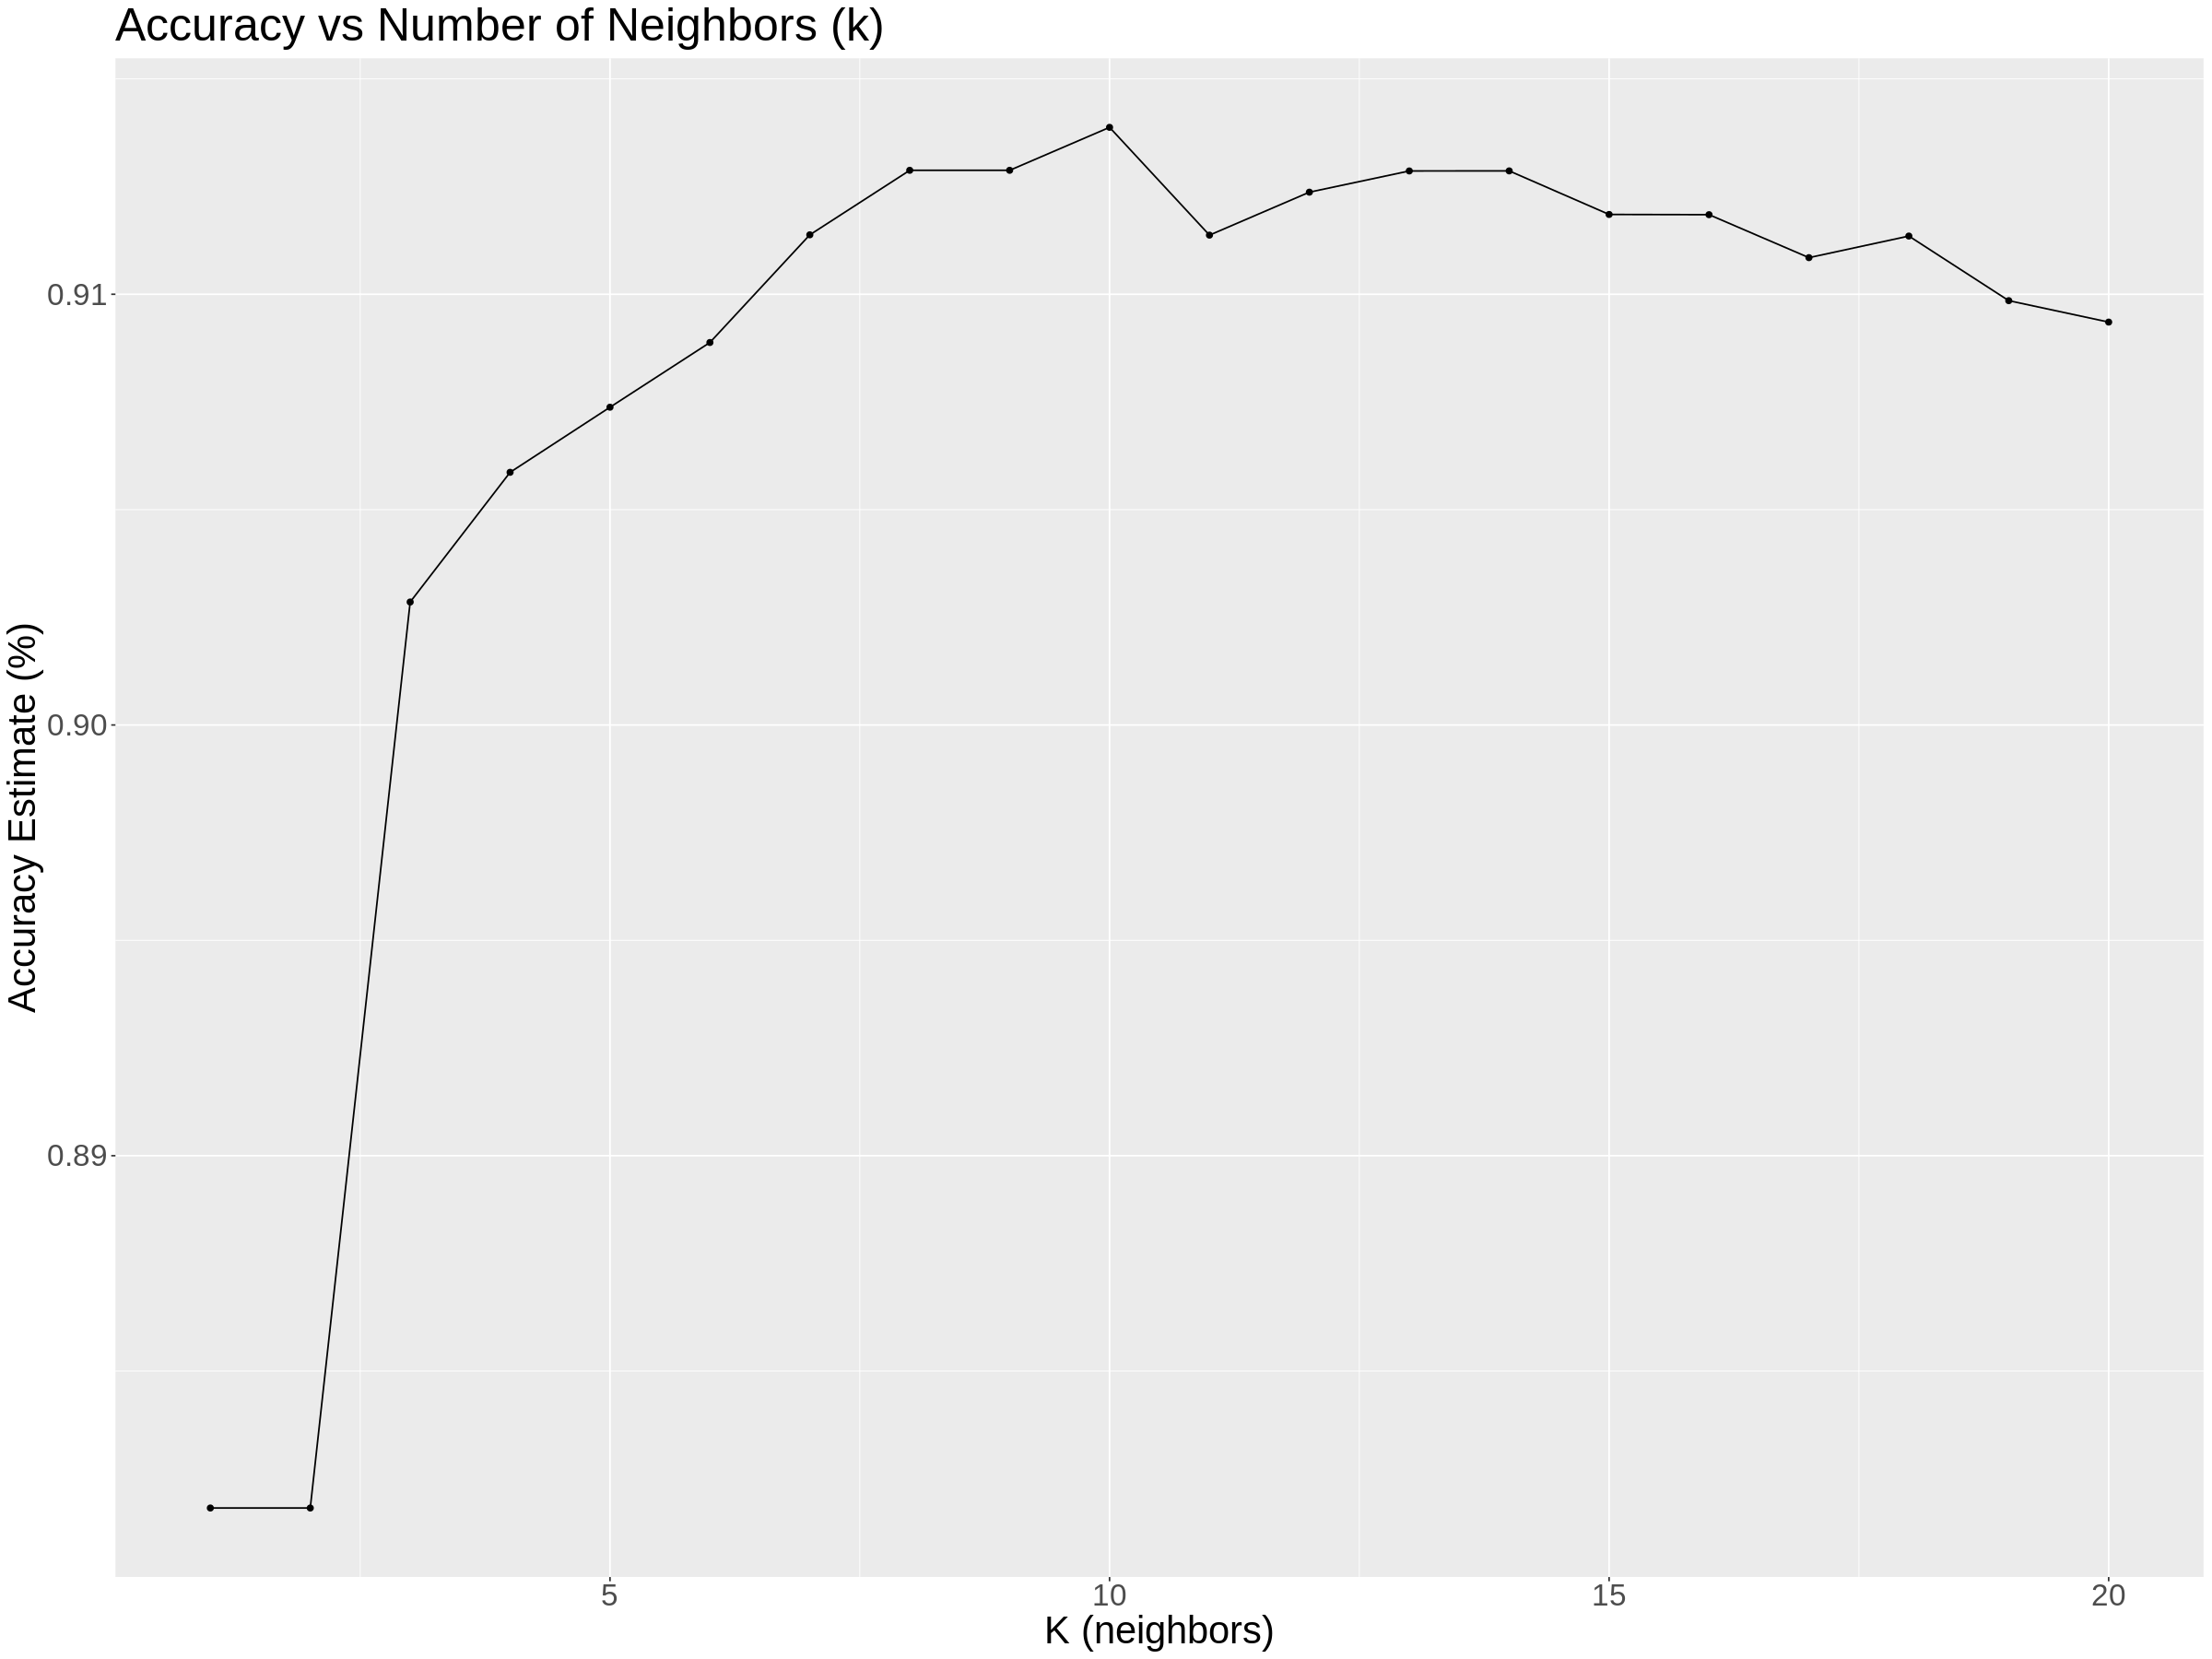

In [22]:
set.seed(2020)
bean_recipe <- recipe(Class ~ ., data = bean_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

bean_vfold <- vfold_cv(bean_data, v = 5, strata = Class)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
    add_recipe(bean_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = bean_vfold, grid = k_vals) |>
    collect_metrics()

accuracies = knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K (neighbors)", y = "Accuracy Estimate (%)", title = "Accuracy vs Number of Neighbors (k)") +
    theme(text = element_text(size = 25))

cross_val_plot

Figure 4. Accuracy estimate versus the number of neighbors (K). 

From figure 4, we see the highest K occurs around 9-10.

In [24]:
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.8432717,5,0.003936815,Preprocessor1_Model01
2,accuracy,multiclass,0.8432717,5,0.003936815,Preprocessor1_Model02
3,accuracy,multiclass,0.8658096,5,0.005334809,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
18,accuracy,multiclass,0.8858323,5,0.004349429,Preprocessor1_Model18
19,accuracy,multiclass,0.8843373,5,0.005334242,Preprocessor1_Model19
20,accuracy,multiclass,0.8848373,5,0.005371252,Preprocessor1_Model20


Table 7. Accuracy for number of neighbors (k = 1 to k = 20). 

From table 7, we see the highest accuracy occurs at K=10.

## Methods Part 7

From the plot and table above, we see that we want to choose K = 10.  Large numbers of predictors can sometimes be inaccurate because they don’t reflect the effectiveness of each variable. Therefore, we decided to test the accuracy of combinations of two or three predictors.

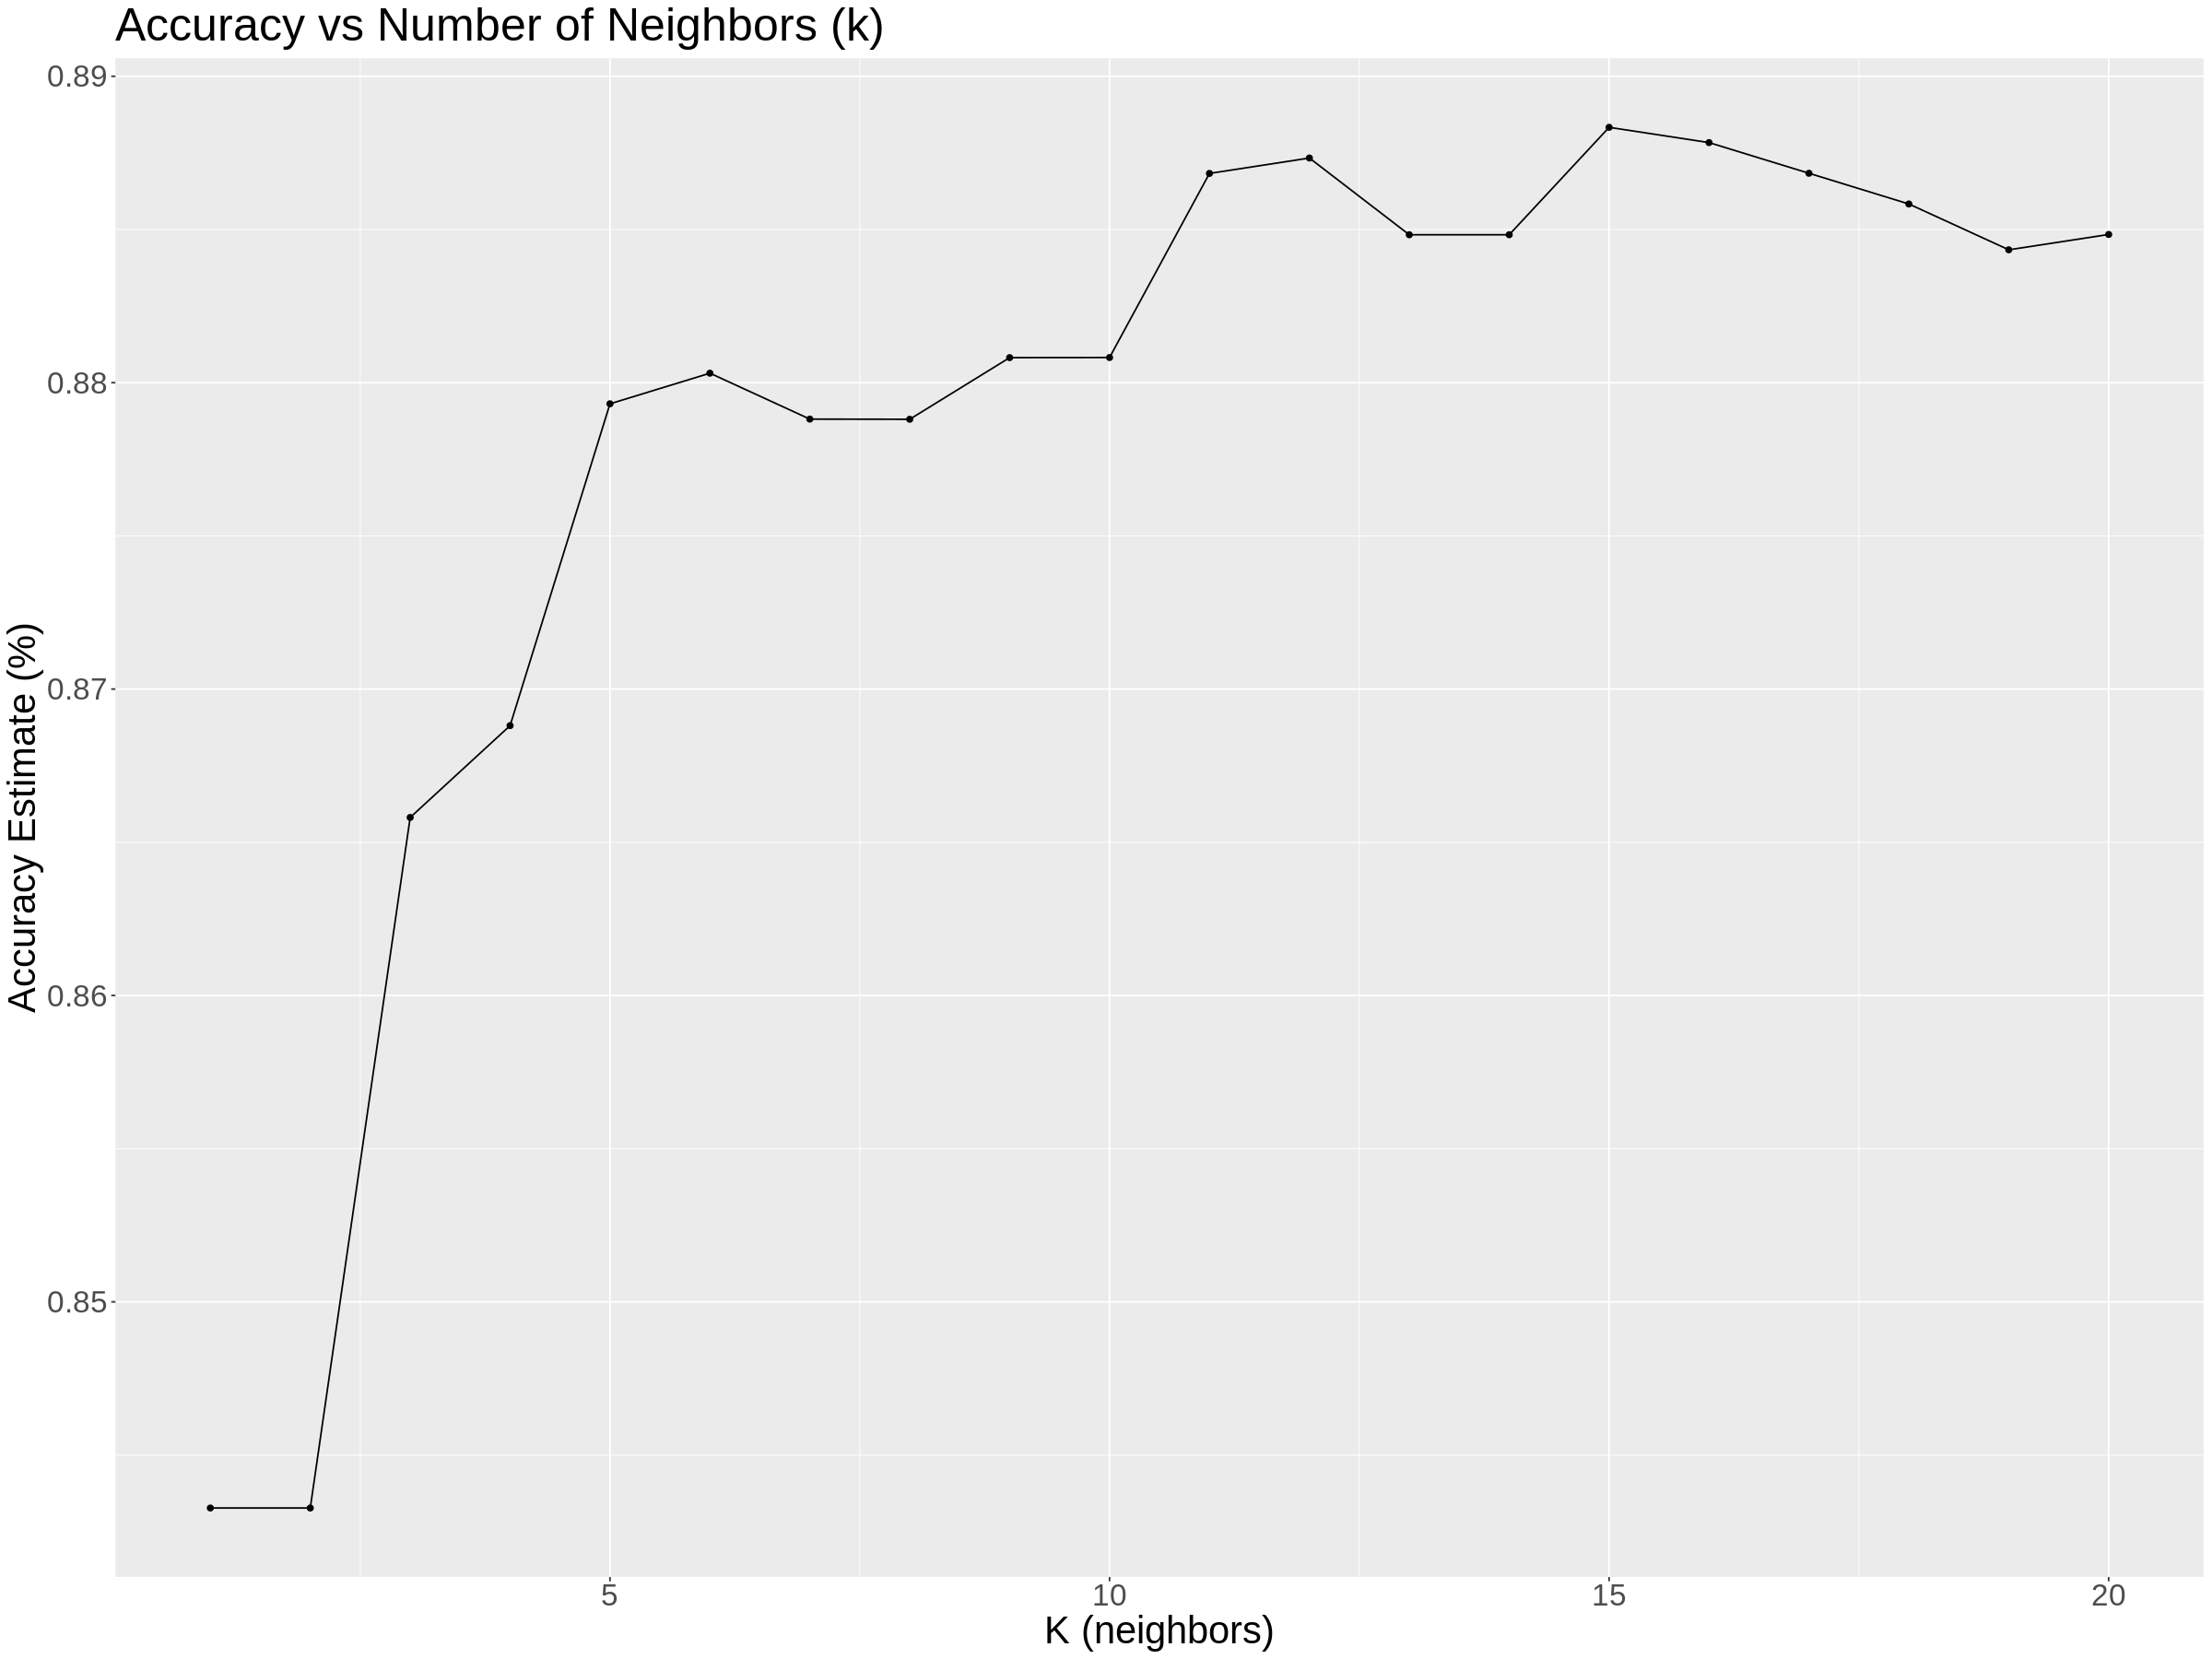

In [23]:
set.seed(2020)

bean_recipe <- recipe(Class ~ Perimeter + Compactness, data = bean_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

bean_vfold <- vfold_cv(bean_data, v = 5, strata = Class)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
    add_recipe(bean_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = bean_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K (neighbors)", y = "Accuracy Estimate (%)", title = "Accuracy vs Number of Neighbors (k)") +
    theme(text = element_text(size = 25))

cross_val_plot

Figure 5. Accuracy estimate versus the number of neighbors (K). 

From figure 5, we see the highest K occurs 15. The accuracy is not as high as figure 6, so we will try other combinations.

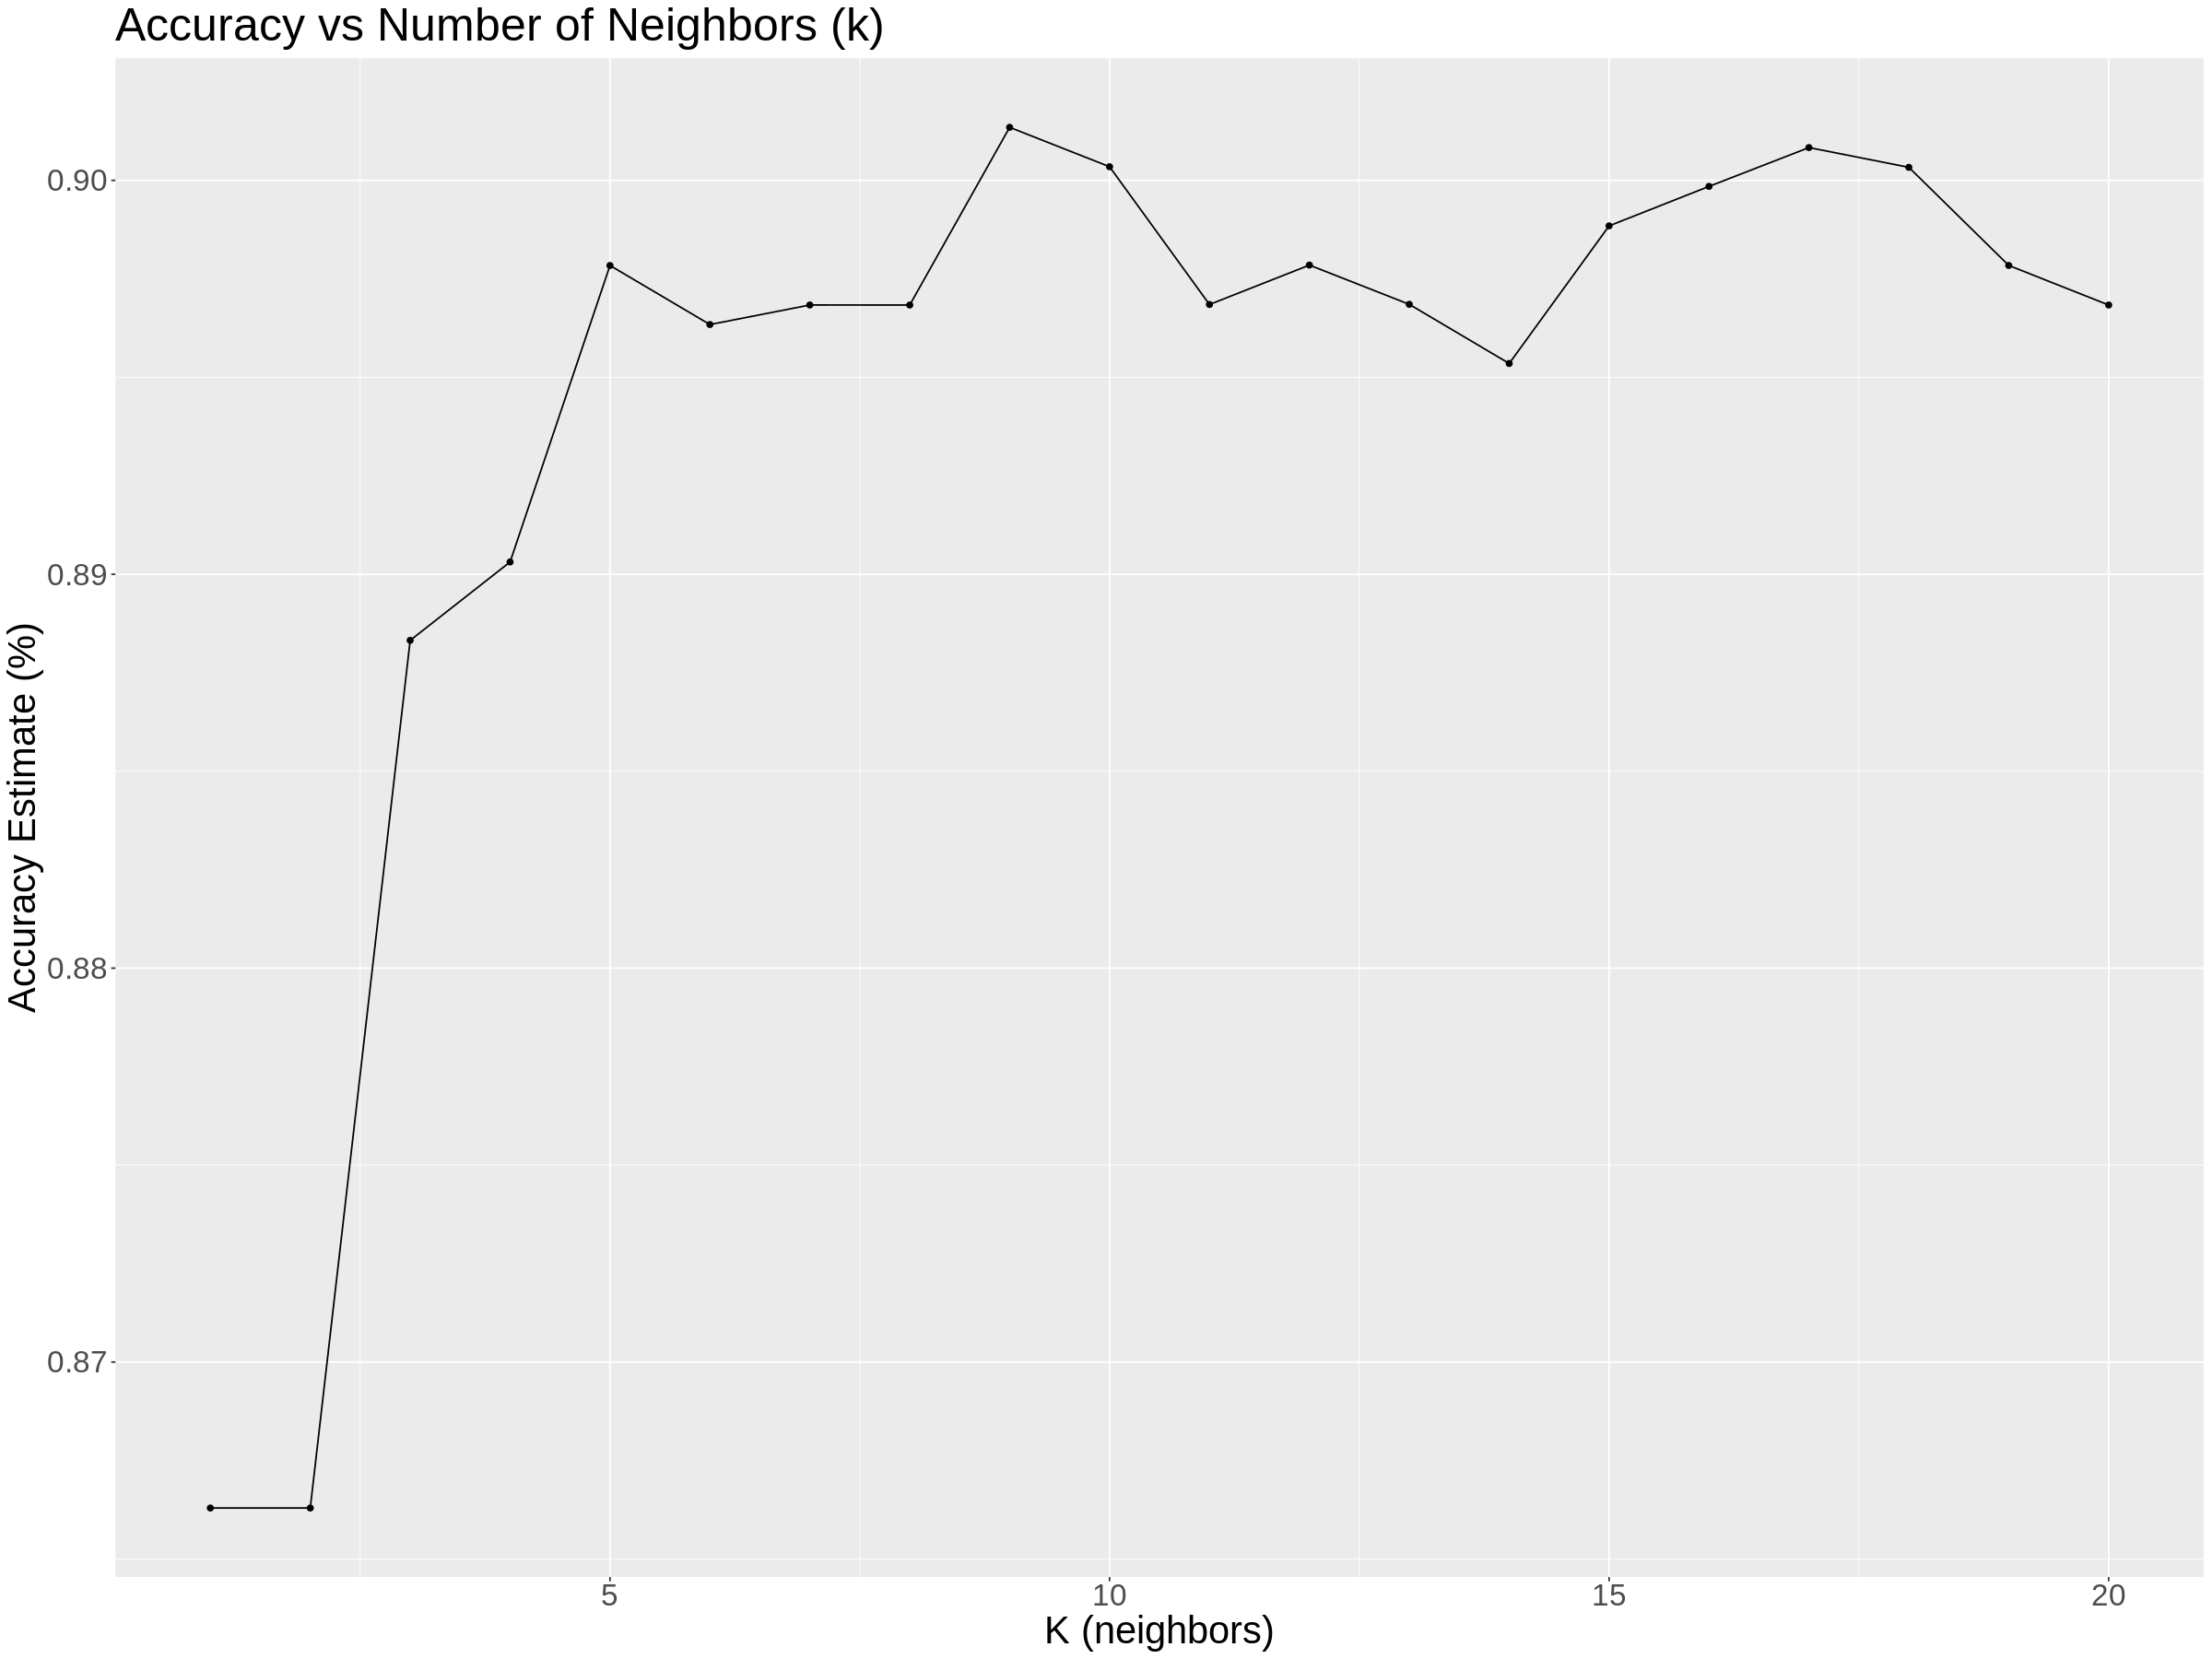

In [26]:
set.seed(2020)

bean_recipe <- recipe(Class ~ MinorAxisLength + Compactness + Perimeter, data = bean_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

bean_vfold <- vfold_cv(bean_data, v = 5, strata = Class)

k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

knn_results <- workflow() |>
    add_recipe(bean_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = bean_vfold, grid = k_vals) |>
    collect_metrics()

accuracies = knn_results |>
    filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K (neighbors)", y = "Accuracy Estimate (%)", title = "Accuracy vs Number of Neighbors (k)") +
    theme(text = element_text(size = 25))

cross_val_plot

Figure 6. Accuracy estimate versus the number of neighbors (K). The highest K occurs around 9-10.

With three predictors, we are getting similar accuracy as the model with nine predictors, so we will use three instead. From this plot, the accuracy is at it's peak around 9-10 and we will choose K = 9.

## Methods Part 7

The final step of this project is conducting a prediction and checking the accuracy of our model. For this we use the testing subset and the function predict to apply our model bean_fit and targeted data bean_data_test. To better evaluate the final result, we first used bind_cols to combine the test dataset with the results and use as_factor to convert the class column into the right format. 

In [ ]:
set.seed(2020)

bean_final_recipe<-recipe(Class ~ MinorAxisLength + Compactness + Perimeter, data = bean_data_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())


knn_spec_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")


bean_fit<-workflow()|>
        add_recipe(bean_final_recipe)|>
        add_model(knn_spec_final)|>
        fit(bean_data_train)
bean_fit


In [34]:
bean_test_predictions<-predict(bean_fit,bean_data_test)|>
    bind_cols(bean_data_test)|>
    arrange(Class)|>
    mutate(Class=as_factor(Class))

fruit_prediction_accuracy <- bean_test_predictions |>
        metrics(truth = Class, estimate = .pred_class)|>
        filter(.metric=="accuracy")

fruit_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8866799


Table 8. Accuracy of the predictor on test data.

The table indicates that the accuracy of this prediction is 88.66%, which is an excellent outcome since it is not unnaturally high but still accurate. Furthermore, 88.66% is reasonable since we are predicting dry bean variety which does not have consequential results if it is wrong.

In [35]:
bean_prediction_truth_mat<-bean_test_predictions |>
        conf_mat(truth = Class, estimate = .pred_class)

bean_prediction_truth_mat

          Truth
Prediction BARBUNYA BOMBAY CALI DERMASON HOROZ SEKER SIRA
  BARBUNYA       39      0    2        0     1     0    0
  BOMBAY          0     27    0        0     0     0    0
  CALI            9      0   51        0     2     0    0
  DERMASON        0      0    0      120     1     2   12
  HOROZ           0      0    1        0    61     0    2
  SEKER           0      0    0        4     0    70    3
  SIRA            4      0    1        8     3     2   78

Table 9. Confusion/truth matrix for prediction of bean type. 

In conclusion, the accuracy is high for most of the bean type predictions; even though the accuracy is a little bit lower for some bean types, most of the accuracy is above 80%, and the overall performance is excellent.From this we see beans are predicted correctly most of the time with a few errors. The most significant error is that barbunya and sira beans have the greatest chance of being misclassified.

## Discussion

After completing most of the data analysis evaluating our final results, we concluded that our prediction was approximately 88.67% accurate. This is a good value since it is high to a reasonable extent. From the truth matrix we are also able to deduce that, out of all the bean types (Barbunya, Bombay, Cali, Dermason, Horoz, Seker, Sira), the Bombay bean had 100% accuracy. The Barbunya bean had a 75% accuracy (39/52) which classifies it as the bean type with the lowest accuracy. Cali beans had around 94.44% accuracy which was the average. The dermason beans had a pretty high accuracy of 93.75%. The rest of the beans were relatively similar coming in at 89.7%, 94.6% and 82.1% for Horoz, Seker and Sira respectively. Overall, the range of accuracy is not too different with a range of around 22% between our highest and lowest outcomes. The values are all still relatively high (perhaps excluding the Barbunya bean type).

We expected to find how dry bean classification varies with factors mostly relating to size and appearance which we were able to do at a high accuracy level. This outcome would be quite impactful specifically for people interested in farming/agriculture or perhaps from a culinary perspective. The article “Combining discriminant analysis and neural networks for corn variety identification” greatly emphasizes the importance of plant/seed identification in the grain marketing industry, this is a really prominent process for farmers and bulk handlers in order for them to ensure the correct products are grown/harvested. So this is a process that affects everyone handling these products from the farmers to the marketers. Automatic variety identification through machinery has been favored since machine vision takes more accurate and consistent measurements as opposed to the slow traditional methods.

After classifying the type of bean we could dig deeper into more comparative questions and rank them by different qualities to determine the best quality to help consumers. We could also look into the prices or popularity according to region, this would be helpful for sellers to maximize their profit.

## References

Campbell, T., & Timbers, T. (2022, September 24). Data science. Chapter 6 Classification II: evaluation & tuning. Retrieved December 6, 2022, from https://datasciencebook.ca/classification2.html 

Chen, X., Xun, Y., Li, W., &amp; Zhang, J. (2010). Combining discriminant analysis and neural networks for corn variety identification. Computers and Electronics in Agriculture, 71, 48–53. https://doi.org/10.1016/j.compag.2009.09.003 

Dutta, G. (2022, October 14). Dry Bean Classification. Kaggle. Retrieved December 6, 2022, from https://www.kaggle.com/datasets/gauravduttakiit/dry-bean-classification 

Koklu, M., & Ozkan, I. A. (2020). Multiclass classification of dry beans using computer vision and Machine Learning Techniques. Computers and Electronics in Agriculture, 174, 105507. https://doi.org/10.1016/j.compag.2020.105507 

Kiratiratanapruk, K. and Sinthupinyo W. (2011). Color and texture for corn seed classification by machine vision. International Symposium on Intelligent Signal Processing and Communications Systems (ISPACS), 59, 6146100, https://doi.org/10.1109/ISPACS.2011.6146100.